**RESNET50**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping

In [ ]:
train_path = "/content/drive/MyDrive/Project_pneumonia_detection/chest_xray/train/"
val_path = "/content/drive/MyDrive/Project_pneumonia_detection/chest_xray/val/"
test_path = "/content/drive/MyDrive/Project_pneumonia_detection/chest_xray/test/"

In [ ]:
normal = glob.glob(train_path+"NORMAL/*.jpeg")
pneumonia = glob.glob(train_path+"PNEUMONIA/*.jpeg")

In [ ]:
number_of_normal_img = len(normal)
number_of_pneumonia_img = len(pneumonia)
print("number of normal images:", number_of_normal_img)
print("number of pneumonia images:", number_of_pneumonia_img)

number of normal images: 1341
number of pneumonia images: 3875


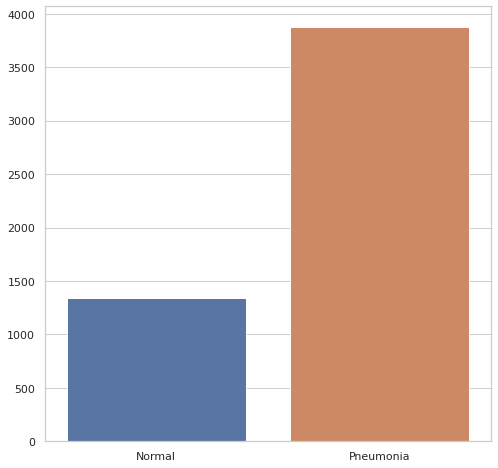

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot( x = ["Normal", "Pneumonia"], y = [number_of_normal_img, number_of_pneumonia_img])

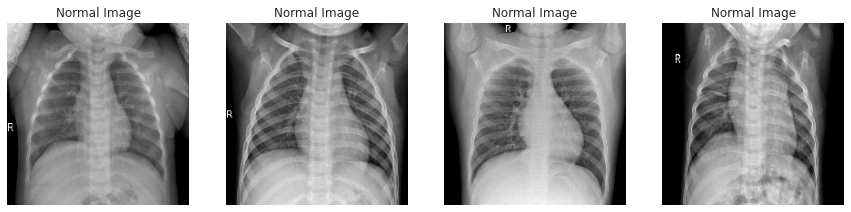

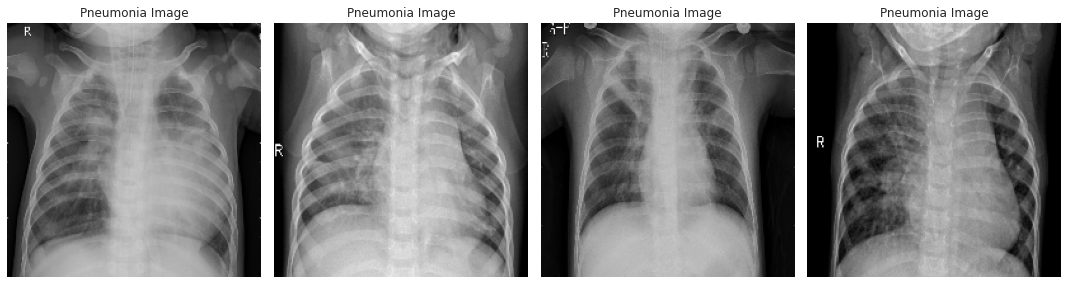

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Normal Image")
    
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Pneumonia Image")
fig.tight_layout()    
plt.show()

In [ ]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=128,
                                               target_size=(200,200),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 5216 images belonging to 2 classes.


In [ ]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=4,
                                               target_size=(200,200),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [ ]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=32,
                                          target_size=(200,200),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (200,200,3), include_top = False)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

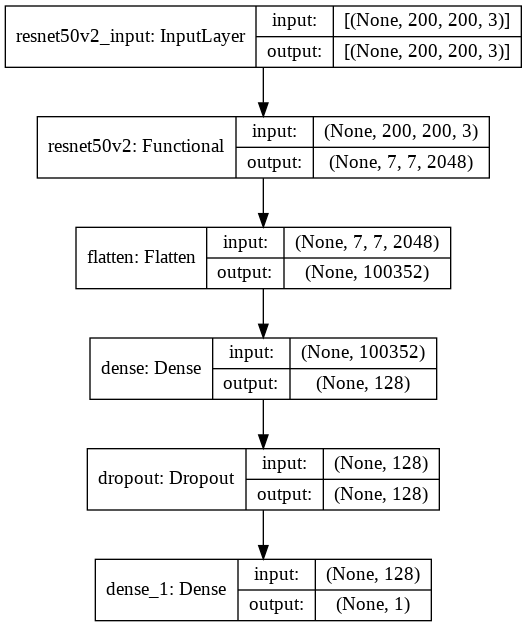

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)

In [ ]:
history = model.fit(train,validation_data=val,epochs=10)

Epoch 1/10
41/41 [==============================] - 2304s 57s/step - loss: 0.7741 - accuracy: 0.8698 - val_loss: 1.1883 - val_accuracy: 0.7500
Epoch 2/10
41/41 [==============================] - 498s 12s/step - loss: 0.2125 - accuracy: 0.9216 - val_loss: 1.0081 - val_accuracy: 0.7500
Epoch 3/10
41/41 [==============================] - 494s 12s/step - loss: 0.1797 - accuracy: 0.9383 - val_loss: 0.9244 - val_accuracy: 0.7500
Epoch 4/10
41/41 [==============================] - 494s 12s/step - loss: 0.1522 - accuracy: 0.9457 - val_loss: 0.5589 - val_accuracy: 0.8750
Epoch 5/10
41/41 [==============================] - 501s 12s/step - loss: 0.1539 - accuracy: 0.9459 - val_loss: 0.6684 - val_accuracy: 0.8750
Epoch 6/10
41/41 [==============================] - 506s 12s/step - loss: 0.1327 - accuracy: 0.9553 - val_loss: 0.6618 - val_accuracy: 0.6875
Epoch 7/10
41/41 [==============================] - 503s 12s/step - loss: 0.1259 - accuracy: 0.9536 - val_loss: 0.8280 - val_accuracy: 0.7500
Epoch

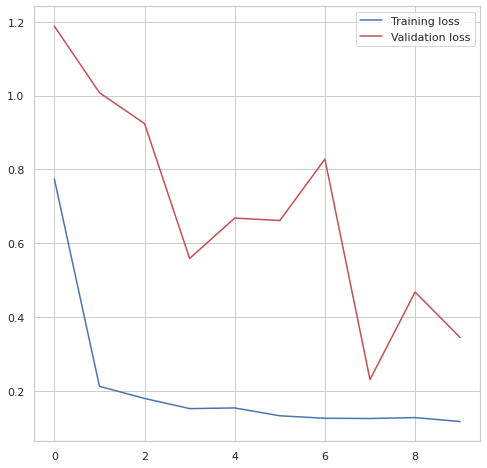

<Figure size 432x288 with 0 Axes>

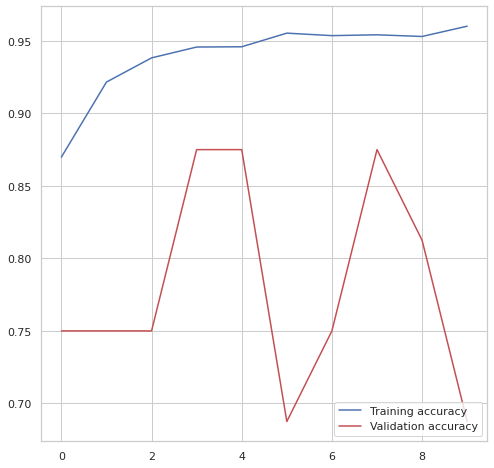

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [ ]:
score = model.evaluate(test, verbose = True)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

20/20 [==============================] - 56s 3s/step - loss: 0.2187 - accuracy: 0.9311
Test loss: 21.86821848154068%
Test accuracy: 93.10897588729858%


In [ ]:
y_pred = model.predict(train)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
y_pre_test = np.argmax(test, axis = 1)

In [ ]:
print(classification_report(y_pre_test, y_pred))